In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

# interp1, 2 are the parameter values, starting from 0
interp1 = 4 # in reality, param no. interp1+1
interp2 = 5 # in reality, param no. interp2+1


n_epochs = 10000
n_epochs_latent=50
batch_size = 1
LR = 2e-5
Lv1_latent_dim = 64
Lv2_latent_dim = 32
epoch_1 = 300

alpha = 0

In [10]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d_batchnorm' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)

In [11]:
f.shape

(10, 800, 64)

## Scale latent codes from Lv 1.

In [12]:
maximum = np.amax(f)
minimum = np.amin(f)
mean = np.mean(f)
AT = maximum-minimum

f = f-mean
f = f/AT

In [13]:
print(np.max(f))
print(np.min(f))

0.5204904498505617
-0.47950955014943836


# Level 2, TVAE (Temporal VAE)

In [14]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 800, 64)

In [15]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]

In [16]:
Lv2_input_shape = Lv2_input.shape[1:]

In [17]:
print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 800, 64)
(800, 64)


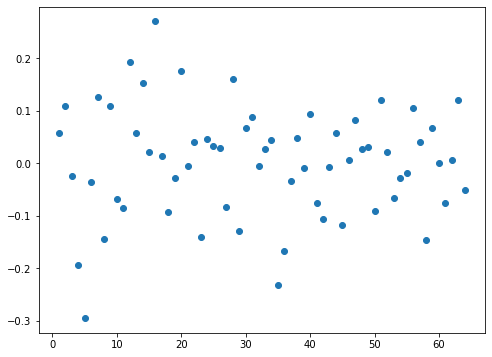

In [18]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
plt.scatter(x_axis1, Lv2_input[0,0,:])

# Encoder

In [19]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 64)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 64)      20544       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 64)      0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

# Decoder

In [20]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

32
800


In [21]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
       
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 25600)        844800      input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 25600)        0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 800, 32)      0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

# loss computation

In [22]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [24]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_Lv2/decoder_%d_batchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_Lv2/encoder_%d_batchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [25]:
Lv2_input.shape
print(type(Lv2_input))

<class 'numpy.ndarray'>


# Warm up

In [26]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/10000
10/10 [==============================] - 6s 10ms/step - loss: -138.0935
Epoch 2/10000
10/10 [==============================] - 0s 9ms/step - loss: -138.4638
Epoch 3/10000
10/10 [==============================] - 0s 10ms/step - loss: -139.8342
Epoch 4/10000
10/10 [==============================] - 0s 8ms/step - loss: -143.2934
Epoch 5/10000
10/10 [==============================] - 0s 10ms/step - loss: -148.5497
Epoch 6/10000
10/10 [==============================] - 0s 10ms/step - loss: -154.7942
Epoch 7/10000
10/10 [==============================] - 0s 11ms/step - loss: -160.8039
Epoch 8/10000
10/10 [==============================] - 0s 9ms/step - loss: -166.6209
Epoch 9/10000
10/10 [==============================] - 0s 8ms/step - loss: -170.9777
Epoch 10/10000
10/10 [==============================] - 0s 11ms/step - loss: -175.9246
Epoch 11/10000
10/10 [==============================] - 0s 11ms/step - loss: -180.4471
Epoch 12/10000
10/10 [==============================] - 

10/10 [==============================] - 0s 9ms/step - loss: -397.9608
Epoch 96/10000
10/10 [==============================] - 0s 10ms/step - loss: -398.7230
Epoch 97/10000
10/10 [==============================] - ETA: 0s - loss: -402.63 - 0s 10ms/step - loss: -401.6675
Epoch 98/10000
10/10 [==============================] - 0s 8ms/step - loss: -402.9788
Epoch 99/10000
10/10 [==============================] - 0s 10ms/step - loss: -404.7401
Epoch 100/10000
10/10 [==============================] - 0s 10ms/step - loss: -406.2189
Epoch 101/10000
10/10 [==============================] - 0s 9ms/step - loss: -408.8317
Epoch 102/10000
10/10 [==============================] - 0s 10ms/step - loss: -411.7336
Epoch 103/10000
10/10 [==============================] - 0s 9ms/step - loss: -411.7864
Epoch 104/10000
10/10 [==============================] - 0s 10ms/step - loss: -412.6686
Epoch 105/10000
10/10 [==============================] - 0s 10ms/step - loss: -413.7140
Epoch 106/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -545.8866
Epoch 189/10000
10/10 [==============================] - 0s 10ms/step - loss: -543.9009
Epoch 190/10000
10/10 [==============================] - 0s 10ms/step - loss: -548.7091
Epoch 191/10000
10/10 [==============================] - 0s 10ms/step - loss: -551.7085
Epoch 192/10000
10/10 [==============================] - 0s 10ms/step - loss: -551.0864
Epoch 193/10000
10/10 [==============================] - 0s 11ms/step - loss: -553.4538
Epoch 194/10000
10/10 [==============================] - 0s 10ms/step - loss: -555.0567
Epoch 195/10000
10/10 [==============================] - 0s 12ms/step - loss: -557.3237
Epoch 196/10000
10/10 [==============================] - 0s 11ms/step - loss: -557.3271
Epoch 197/10000
10/10 [==============================] - 0s 9ms/step - loss: -558.0279
Epoch 198/10000
10/10 [==============================] - 0s 10ms/step - loss: -560.6314
Epoch 199/10000
10/10 [===========================

10/10 [==============================] - 0s 9ms/step - loss: -672.2712
Epoch 282/10000
10/10 [==============================] - 0s 9ms/step - loss: -674.2263
Epoch 283/10000
10/10 [==============================] - 0s 9ms/step - loss: -675.5064
Epoch 284/10000
10/10 [==============================] - 0s 11ms/step - loss: -676.9189
Epoch 285/10000
10/10 [==============================] - 0s 11ms/step - loss: -679.1710
Epoch 286/10000
10/10 [==============================] - 0s 12ms/step - loss: -678.2583
Epoch 287/10000
10/10 [==============================] - 0s 12ms/step - loss: -679.5313
Epoch 288/10000
10/10 [==============================] - 0s 11ms/step - loss: -682.6773
Epoch 289/10000
10/10 [==============================] - 0s 9ms/step - loss: -681.4142
Epoch 290/10000
10/10 [==============================] - 0s 10ms/step - loss: -685.2002
Epoch 291/10000
10/10 [==============================] - 0s 11ms/step - loss: -684.5025
Epoch 292/10000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: -786.5457
Epoch 375/10000
10/10 [==============================] - 0s 10ms/step - loss: -786.6382
Epoch 376/10000
10/10 [==============================] - 0s 10ms/step - loss: -792.7062
Epoch 377/10000
10/10 [==============================] - 0s 9ms/step - loss: -790.9655
Epoch 378/10000
10/10 [==============================] - 0s 11ms/step - loss: -792.7967
Epoch 379/10000
10/10 [==============================] - 0s 11ms/step - loss: -792.2611
Epoch 380/10000
10/10 [==============================] - 0s 9ms/step - loss: -796.5409
Epoch 381/10000
10/10 [==============================] - 0s 8ms/step - loss: -794.4771
Epoch 382/10000
10/10 [==============================] - 0s 9ms/step - loss: -794.8928
Epoch 383/10000
10/10 [==============================] - 0s 10ms/step - loss: -796.6091
Epoch 384/10000
10/10 [==============================] - 0s 9ms/step - loss: -803.6907
Epoch 385/10000
10/10 [==============================]

10/10 [==============================] - 0s 10ms/step - loss: -900.5630
Epoch 468/10000
10/10 [==============================] - 0s 10ms/step - loss: -895.7916
Epoch 469/10000
10/10 [==============================] - 0s 9ms/step - loss: -902.6233
Epoch 470/10000
10/10 [==============================] - 0s 9ms/step - loss: -906.9678
Epoch 471/10000
10/10 [==============================] - 0s 10ms/step - loss: -904.9543
Epoch 472/10000
10/10 [==============================] - 0s 8ms/step - loss: -905.9409
Epoch 473/10000
10/10 [==============================] - 0s 8ms/step - loss: -900.3065
Epoch 474/10000
10/10 [==============================] - 0s 11ms/step - loss: -911.2651
Epoch 475/10000
10/10 [==============================] - 0s 9ms/step - loss: -906.8112
Epoch 476/10000
10/10 [==============================] - 0s 11ms/step - loss: -912.7717
Epoch 477/10000
10/10 [==============================] - 0s 11ms/step - loss: -910.8212
Epoch 478/10000
10/10 [==============================

10/10 [==============================] - 0s 9ms/step - loss: -997.7132
Epoch 561/10000
10/10 [==============================] - 0s 10ms/step - loss: -1002.3326
Epoch 562/10000
10/10 [==============================] - 0s 10ms/step - loss: -1009.2098
Epoch 563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1011.1803
Epoch 564/10000
10/10 [==============================] - 0s 10ms/step - loss: -1012.6832
Epoch 565/10000
10/10 [==============================] - 0s 10ms/step - loss: -1013.4474
Epoch 566/10000
10/10 [==============================] - 0s 10ms/step - loss: -1011.8801
Epoch 567/10000
10/10 [==============================] - 0s 10ms/step - loss: -1013.7014
Epoch 568/10000
10/10 [==============================] - 0s 11ms/step - loss: -1014.9667
Epoch 569/10000
10/10 [==============================] - 0s 8ms/step - loss: -1015.6390
Epoch 570/10000
10/10 [==============================] - 0s 10ms/step - loss: -1019.8585
Epoch 571/10000
10/10 [=================

10/10 [==============================] - 0s 9ms/step - loss: -1109.0754
Epoch 653/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.9933
Epoch 654/10000
10/10 [==============================] - 0s 11ms/step - loss: -1110.0913
Epoch 655/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.8427
Epoch 656/10000
10/10 [==============================] - 0s 9ms/step - loss: -1113.4170
Epoch 657/10000
10/10 [==============================] - 0s 11ms/step - loss: -1111.1985
Epoch 658/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.0539
Epoch 659/10000
10/10 [==============================] - 0s 11ms/step - loss: -1112.9799
Epoch 660/10000
10/10 [==============================] - 0s 8ms/step - loss: -1116.7658
Epoch 661/10000
10/10 [==============================] - 0s 10ms/step - loss: -1116.9364
Epoch 662/10000
10/10 [==============================] - 0s 10ms/step - loss: -1116.6846
Epoch 663/10000
10/10 [====================

10/10 [==============================] - 0s 10ms/step - loss: -1198.2550
Epoch 745/10000
10/10 [==============================] - 0s 13ms/step - loss: -1199.1640
Epoch 746/10000
10/10 [==============================] - 0s 12ms/step - loss: -1206.9701
Epoch 747/10000
10/10 [==============================] - 0s 10ms/step - loss: -1201.7460
Epoch 748/10000
10/10 [==============================] - 0s 9ms/step - loss: -1207.5715
Epoch 749/10000
10/10 [==============================] - 0s 11ms/step - loss: -1209.0270
Epoch 750/10000
10/10 [==============================] - 0s 9ms/step - loss: -1211.5570
Epoch 751/10000
10/10 [==============================] - 0s 11ms/step - loss: -1212.9430
Epoch 752/10000
10/10 [==============================] - 0s 10ms/step - loss: -1211.2984
Epoch 753/10000
10/10 [==============================] - 0s 11ms/step - loss: -1201.4771
Epoch 754/10000
10/10 [==============================] - 0s 10ms/step - loss: -1210.2896
Epoch 755/10000
10/10 [================

10/10 [==============================] - 0s 9ms/step - loss: -1286.3124
Epoch 837/10000
10/10 [==============================] - 0s 11ms/step - loss: -1285.6064
Epoch 838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1279.2122
Epoch 839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1294.1900
Epoch 840/10000
10/10 [==============================] - 0s 11ms/step - loss: -1284.0898
Epoch 841/10000
10/10 [==============================] - 0s 10ms/step - loss: -1291.4029
Epoch 842/10000
10/10 [==============================] - 0s 9ms/step - loss: -1290.6603
Epoch 843/10000
10/10 [==============================] - 0s 10ms/step - loss: -1289.6293
Epoch 844/10000
10/10 [==============================] - 0s 10ms/step - loss: -1296.5161
Epoch 845/10000
10/10 [==============================] - 0s 9ms/step - loss: -1276.3410
Epoch 846/10000
10/10 [==============================] - 0s 9ms/step - loss: -1288.3211
Epoch 847/10000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: -1361.6067
Epoch 929/10000
10/10 [==============================] - 0s 10ms/step - loss: -1361.9449
Epoch 930/10000
10/10 [==============================] - 0s 9ms/step - loss: -1359.7164
Epoch 931/10000
10/10 [==============================] - 0s 9ms/step - loss: -1347.9278
Epoch 932/10000
10/10 [==============================] - 0s 9ms/step - loss: -1362.6094
Epoch 933/10000
10/10 [==============================] - 0s 9ms/step - loss: -1364.5700
Epoch 934/10000
10/10 [==============================] - 0s 11ms/step - loss: -1358.1348
Epoch 935/10000
10/10 [==============================] - 0s 10ms/step - loss: -1365.2279
Epoch 936/10000
10/10 [==============================] - 0s 8ms/step - loss: -1368.2678
Epoch 937/10000
10/10 [==============================] - 0s 9ms/step - loss: -1346.2996
Epoch 938/10000
10/10 [==============================] - 0s 9ms/step - loss: -1364.0157
Epoch 939/10000
10/10 [======================

10/10 [==============================] - 0s 10ms/step - loss: -1407.7897
Epoch 1017/10000
10/10 [==============================] - 0s 8ms/step - loss: -1409.4228
Epoch 1018/10000
10/10 [==============================] - 0s 10ms/step - loss: -1418.7261
Epoch 1019/10000
10/10 [==============================] - 0s 9ms/step - loss: -1408.8389
Epoch 1020/10000
10/10 [==============================] - 0s 10ms/step - loss: -1415.2792
Epoch 1021/10000
10/10 [==============================] - 0s 10ms/step - loss: -1413.7052
Epoch 1022/10000
10/10 [==============================] - 0s 10ms/step - loss: -1408.9711
Epoch 1023/10000
10/10 [==============================] - 0s 9ms/step - loss: -1413.0907
Epoch 1024/10000
10/10 [==============================] - 0s 10ms/step - loss: -1418.5348
Epoch 1025/10000
10/10 [==============================] - 0s 11ms/step - loss: -1405.6209
Epoch 1026/10000
10/10 [==============================] - 0s 8ms/step - loss: -1395.2772
Epoch 1027/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1447.8722
Epoch 1108/10000
10/10 [==============================] - 0s 11ms/step - loss: -1459.5617
Epoch 1109/10000
10/10 [==============================] - 0s 11ms/step - loss: -1454.9481
Epoch 1110/10000
10/10 [==============================] - 0s 10ms/step - loss: -1461.0736
Epoch 1111/10000
10/10 [==============================] - 0s 10ms/step - loss: -1471.1976
Epoch 1112/10000
10/10 [==============================] - 0s 12ms/step - loss: -1471.0376
Epoch 1113/10000
10/10 [==============================] - 0s 10ms/step - loss: -1457.4895
Epoch 1114/10000
10/10 [==============================] - 0s 10ms/step - loss: -1463.7935
Epoch 1115/10000
10/10 [==============================] - 0s 9ms/step - loss: -1475.0616
Epoch 1116/10000
10/10 [==============================] - 0s 9ms/step - loss: -1453.7049
Epoch 1117/10000
10/10 [==============================] - 0s 10ms/step - loss: -1474.5161
Epoch 1118/10000
10/10 [=====

10/10 [==============================] - 0s 10ms/step - loss: -1502.8777
Epoch 1199/10000
10/10 [==============================] - 0s 9ms/step - loss: -1474.5800
Epoch 1200/10000
10/10 [==============================] - 0s 10ms/step - loss: -1511.3529
Epoch 1201/10000
10/10 [==============================] - 0s 8ms/step - loss: -1501.9935
Epoch 1202/10000
10/10 [==============================] - 0s 10ms/step - loss: -1487.6807
Epoch 1203/10000
10/10 [==============================] - 0s 10ms/step - loss: -1512.9301
Epoch 1204/10000
10/10 [==============================] - 0s 8ms/step - loss: -1485.8720
Epoch 1205/10000
10/10 [==============================] - 0s 10ms/step - loss: -1493.5691
Epoch 1206/10000
10/10 [==============================] - 0s 9ms/step - loss: -1500.8577
Epoch 1207/10000
10/10 [==============================] - 0s 9ms/step - loss: -1495.2242
Epoch 1208/10000
10/10 [==============================] - 0s 10ms/step - loss: -1510.4013
Epoch 1209/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1525.9259
Epoch 1290/10000
10/10 [==============================] - 0s 11ms/step - loss: -1534.6940
Epoch 1291/10000
10/10 [==============================] - 0s 9ms/step - loss: -1522.6252
Epoch 1292/10000
10/10 [==============================] - 0s 10ms/step - loss: -1506.4799
Epoch 1293/10000
10/10 [==============================] - 0s 10ms/step - loss: -1509.7211
Epoch 1294/10000
10/10 [==============================] - 0s 10ms/step - loss: -1515.1889
Epoch 1295/10000
10/10 [==============================] - 0s 11ms/step - loss: -1540.0941
Epoch 1296/10000
10/10 [==============================] - 0s 10ms/step - loss: -1540.8205
Epoch 1297/10000
10/10 [==============================] - 0s 8ms/step - loss: -1532.4620
Epoch 1298/10000
10/10 [==============================] - 0s 10ms/step - loss: -1544.0339
Epoch 1299/10000
10/10 [==============================] - 0s 10ms/step - loss: -1525.7078
Epoch 1300/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1557.6077
Epoch 1381/10000
10/10 [==============================] - 0s 8ms/step - loss: -1563.5367
Epoch 1382/10000
10/10 [==============================] - 0s 10ms/step - loss: -1560.3503
Epoch 1383/10000
10/10 [==============================] - 0s 10ms/step - loss: -1572.8150
Epoch 1384/10000
10/10 [==============================] - 0s 9ms/step - loss: -1557.1098
Epoch 1385/10000
10/10 [==============================] - 0s 9ms/step - loss: -1530.6758
Epoch 1386/10000
10/10 [==============================] - 0s 9ms/step - loss: -1558.6666
Epoch 1387/10000
10/10 [==============================] - 0s 10ms/step - loss: -1549.8212
Epoch 1388/10000
10/10 [==============================] - 0s 10ms/step - loss: -1571.3413
Epoch 1389/10000
10/10 [==============================] - 0s 9ms/step - loss: -1532.0143
Epoch 1390/10000
10/10 [==============================] - 0s 9ms/step - loss: -1531.8157
Epoch 1391/10000
10/10 [=========

10/10 [==============================] - 0s 8ms/step - loss: -1572.3997
Epoch 1472/10000
10/10 [==============================] - 0s 10ms/step - loss: -1553.6450
Epoch 1473/10000
10/10 [==============================] - 0s 9ms/step - loss: -1586.0139
Epoch 1474/10000
10/10 [==============================] - 0s 10ms/step - loss: -1591.3686
Epoch 1475/10000
10/10 [==============================] - 0s 10ms/step - loss: -1565.2775
Epoch 1476/10000
10/10 [==============================] - 0s 9ms/step - loss: -1569.5631
Epoch 1477/10000
10/10 [==============================] - 0s 9ms/step - loss: -1557.9176
Epoch 1478/10000
10/10 [==============================] - 0s 9ms/step - loss: -1589.4393
Epoch 1479/10000
10/10 [==============================] - 0s 10ms/step - loss: -1580.7816
Epoch 1480/10000
10/10 [==============================] - 0s 10ms/step - loss: -1592.0744
Epoch 1481/10000
10/10 [==============================] - 0s 10ms/step - loss: -1574.6572
Epoch 1482/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1603.6101
Epoch 1563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1594.8412
Epoch 1564/10000
10/10 [==============================] - 0s 11ms/step - loss: -1608.6004
Epoch 1565/10000
10/10 [==============================] - 0s 10ms/step - loss: -1609.4651
Epoch 1566/10000
10/10 [==============================] - 0s 10ms/step - loss: -1595.5756
Epoch 1567/10000
10/10 [==============================] - 0s 9ms/step - loss: -1596.4311
Epoch 1568/10000
10/10 [==============================] - 0s 9ms/step - loss: -1609.5948
Epoch 1569/10000
10/10 [==============================] - 0s 10ms/step - loss: -1612.6649
Epoch 1570/10000
10/10 [==============================] - 0s 9ms/step - loss: -1593.1422
Epoch 1571/10000
10/10 [==============================] - 0s 9ms/step - loss: -1613.7654
Epoch 1572/10000
10/10 [==============================] - 0s 9ms/step - loss: -1597.7331
Epoch 1573/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1606.9811
Epoch 1654/10000
10/10 [==============================] - 0s 11ms/step - loss: -1609.6746
Epoch 1655/10000
10/10 [==============================] - 0s 10ms/step - loss: -1631.9496
Epoch 1656/10000
10/10 [==============================] - 0s 11ms/step - loss: -1611.1223
Epoch 1657/10000
10/10 [==============================] - 0s 9ms/step - loss: -1624.3741
Epoch 1658/10000
10/10 [==============================] - 0s 10ms/step - loss: -1630.2041
Epoch 1659/10000
10/10 [==============================] - 0s 10ms/step - loss: -1617.4169
Epoch 1660/10000
10/10 [==============================] - 0s 9ms/step - loss: -1618.8936
Epoch 1661/10000
10/10 [==============================] - 0s 9ms/step - loss: -1631.7702
Epoch 1662/10000
10/10 [==============================] - 0s 10ms/step - loss: -1616.2589
Epoch 1663/10000
10/10 [==============================] - 0s 10ms/step - loss: -1615.1149
Epoch 1664/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1633.3576
Epoch 1745/10000
10/10 [==============================] - 0s 10ms/step - loss: -1647.6576
Epoch 1746/10000
10/10 [==============================] - 0s 10ms/step - loss: -1629.8818
Epoch 1747/10000
10/10 [==============================] - 0s 10ms/step - loss: -1633.5061
Epoch 1748/10000
10/10 [==============================] - 0s 10ms/step - loss: -1623.2306
Epoch 1749/10000
10/10 [==============================] - 0s 9ms/step - loss: -1635.4359
Epoch 1750/10000
10/10 [==============================] - 0s 9ms/step - loss: -1647.3712
Epoch 1751/10000
10/10 [==============================] - 0s 9ms/step - loss: -1626.6537
Epoch 1752/10000
10/10 [==============================] - 0s 10ms/step - loss: -1603.0920
Epoch 1753/10000
10/10 [==============================] - 0s 10ms/step - loss: -1649.9144
Epoch 1754/10000
10/10 [==============================] - 0s 10ms/step - loss: -1631.7210
Epoch 1755/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1640.5599
Epoch 1836/10000
10/10 [==============================] - 0s 10ms/step - loss: -1641.2662
Epoch 1837/10000
10/10 [==============================] - 0s 9ms/step - loss: -1660.0717
Epoch 1838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1653.4409
Epoch 1839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1637.4933
Epoch 1840/10000
10/10 [==============================] - 0s 9ms/step - loss: -1642.7634
Epoch 1841/10000
10/10 [==============================] - 0s 9ms/step - loss: -1650.9273
Epoch 1842/10000
10/10 [==============================] - 0s 9ms/step - loss: -1658.1746
Epoch 1843/10000
10/10 [==============================] - 0s 8ms/step - loss: -1650.0510
Epoch 1844/10000
10/10 [==============================] - 0s 10ms/step - loss: -1638.7868
Epoch 1845/10000
10/10 [==============================] - 0s 10ms/step - loss: -1664.4943
Epoch 1846/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1650.8715
Epoch 1927/10000
10/10 [==============================] - 0s 9ms/step - loss: -1651.7289
Epoch 1928/10000
10/10 [==============================] - 0s 11ms/step - loss: -1655.2163
Epoch 1929/10000
10/10 [==============================] - 0s 9ms/step - loss: -1669.8940
Epoch 1930/10000
10/10 [==============================] - 0s 9ms/step - loss: -1644.5925
Epoch 1931/10000
10/10 [==============================] - 0s 9ms/step - loss: -1640.0732
Epoch 1932/10000
10/10 [==============================] - 0s 9ms/step - loss: -1627.8187
Epoch 1933/10000
10/10 [==============================] - 0s 9ms/step - loss: -1648.3190
Epoch 1934/10000
10/10 [==============================] - 0s 11ms/step - loss: -1664.6399
Epoch 1935/10000
10/10 [==============================] - 0s 9ms/step - loss: -1652.0492
Epoch 1936/10000
10/10 [==============================] - 0s 8ms/step - loss: -1653.8027
Epoch 1937/10000
10/10 [============

10/10 [==============================] - 0s 10ms/step - loss: -1676.3839
Epoch 2014/10000
10/10 [==============================] - 0s 10ms/step - loss: -1653.9837
Epoch 2015/10000
10/10 [==============================] - 0s 10ms/step - loss: -1652.8579
Epoch 2016/10000
10/10 [==============================] - 0s 10ms/step - loss: -1656.0446
Epoch 2017/10000
10/10 [==============================] - 0s 10ms/step - loss: -1667.5026
Epoch 2018/10000
10/10 [==============================] - 0s 10ms/step - loss: -1679.6179
Epoch 2019/10000
10/10 [==============================] - 0s 9ms/step - loss: -1651.8896
Epoch 2020/10000
10/10 [==============================] - 0s 9ms/step - loss: -1660.6454
Epoch 2021/10000
10/10 [==============================] - 0s 10ms/step - loss: -1665.4501
Epoch 2022/10000
10/10 [==============================] - 0s 9ms/step - loss: -1634.8756
Epoch 2023/10000
10/10 [==============================] - 0s 9ms/step - loss: -1653.8476
Epoch 2024/10000
10/10 [=======

# Acquire latent vectors

In [ ]:
del Encoder
del Decoder

FOM_data = Lv2_input
FOM_data.shape

In [ ]:

epoch = n_epochs
filename1='test_constrained_Lv2/encoder_%d_batchnorm.h5' % (n_epochs)
filename2='test_constrained_Lv2/decoder_%d_batchnorm.h5' % (n_epochs)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()


In [ ]:
temp_lv2 = np.zeros([1,Lv2_input.shape[1],Lv2_input.shape[2]])
Lv2_latent = np.zeros([num_param, Lv2_latent_dim])

for i in range(num_param):
    temp_lv2[0,:,:] = Lv2_input[i,:,:]
        
    temp3= Encoder(temp_lv2, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
    Lv2_latent[i,:] = np.asarray(temp3)[0,:]

In [ ]:
temp3.shape

In [ ]:
Lv2_latent.shape

In [ ]:
latent_vectors = np.zeros([Lv2_latent.shape[0],Lv2_latent.shape[1]])

latent_vectors = Lv2_latent

In [ ]:
print(Lv2_latent.shape)

In [ ]:
latent_vectors

In [ ]:
x_axis = np.linspace(1,Lv2_latent.shape[1],Lv2_latent.shape[1])
x_axis

# Output latent vectors to file,

In [ ]:
# Save latent vectors for each parameter...

filename3 = 'latent_vectors_Lv2/latent_vector_batchnorm'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [ ]:
# Lv2_input : num_param, num_time, 128

Lv2_input.shape

In [ ]:
validate = Lv2_input[0,:,:]
validate.shape

In [ ]:
latent_val = np.zeros([1, Lv2_latent_dim])

latent_val[0,:] = Lv2_latent[0,:]

In [ ]:
latent_val.shape

In [ ]:
validate_decoder = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

In [ ]:
np.mean(np.abs(validate-validate_decoder))

In [ ]:
validate.shape

In [ ]:
print(validate[0,0])#,validate[0,0,1],validate[0,1,0],validate[0,0,2])

In [ ]:
print(validate_decoder[0,0,0],validate_decoder[0,0,1],validate_decoder[0,1,0],validate_decoder[0,0,2])

In [ ]:
x_axis = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [ ]:
validate_decoder.shape

In [ ]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Reconstruction','Original'],loc='upper left')

# Verify w/ Lv1...

In [ ]:
temp4 = np.zeros([1,Lv2_latent_dim])
temp4[0,:] = Lv2_latent[0,:]

Lv1_latent_decoded = Decoder(temp4)

In [ ]:
Lv2_latent.shape

In [ ]:
Lv1_latent_decoded.shape

In [ ]:
filename2='test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch_1)
Decoder_Lv1 = load_model(filename2)
Decoder_Lv1.summary()

In [ ]:
temp5 = np.zeros([1, Lv1_latent_dim])
temp6 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    temp5[0,:] = Lv1_latent_decoded[0,i,:]
    Lv1_decoded = Decoder_Lv1(temp5)
    temp6[i,:,:]=Lv1_decoded[0,:,:]
    


In [ ]:
Lv1_decoded.shape

In [ ]:
temp6.shape

In [ ]:
x_axis11 = np.linspace(1,num_time, num_time)

plt.scatter(x_axis11, temp6[:,0,0])

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [ ]:
Lv2_latent.shape

In [ ]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

In [ ]:
interp_Lv1_latent = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

In [ ]:
# Unscale

In [ ]:
interp_Lv1_latent = (interp_Lv1_latent*AT)+mean

In [ ]:
print(interp_Lv1_latent[0,0,0ccccccc], f[0,0,0])

In [ ]:
filename4 = 'interpolated_latentcode_batchnorm'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [ ]:
pause;